In [85]:
from inference.run_inference import scrape_and_predict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sentiment_model.evaluation import run_evaluation
import pandas as pd
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS
from sentiment_model.data_utils.tweet_dataset import tokenize, process_token_list
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import os
from utils import get_project_root
from torchtext.vocab import GloVe
import torch
from sentiment_model.data_utils.tweet_dataset import TweetDataset
from pathlib import Path
from sklearn.calibration import CalibratedClassifierCV
from sentiment_model.model_calibration import predict
from sklearn.metrics import classification_report
from utils import pickle_load, pickle_save
from sentiment_model.model_calibration import CalibratedModel
from visualisation.plotting import plot_bar, plot_confusion_matrix, plot_label_count

## Model evaluation

def score_to_cat(predictions: np.array):
    return np.digitize(predictions, [1/3,2/3, 1], right=True)

def transform_sent140_labels(labels):
    return np.digitize(labels, [0.1, 0.6, 1], right=True)

In [2]:
preds, targets, CM = run_evaluation(model_file="lemon-forest-81/lemon-forest-81-epoch-1.pth", num_classes=2, dataset="sent140_multi_class", decision_bound=(0.5208333333333334, 0.625), load_calib_model=True)
# preds = score_to_cat(preds_probs)
# targets = transform_sent140_labels(targets)

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Calibrating model


100%|██████████| 1250/1250 [03:01<00:00,  6.90it/s]


C:\Users\20172613\OneDrive\Documenten\GitHub\product_sentiment\product-sentiment\sentiment_model\checkpoints\calibrated_model


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


Test set accuracy: 0.5963855421686747


In [10]:
# Import GloVe Embeddings
cache_path = os.path.join(get_project_root(), Path("sentiment_model/.vector_cache/"))
glove_twitter = GloVe(name="twitter.27B", dim=50, cache=cache_path)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters and padded characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))

# Load data:
test_dataset = TweetDataset(dataset="sent140_multi_class", split="test", pretrained_vecs=glove_twitter)

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def create_test_df(preds, targets, softmax_output=False):
    if softmax_output:
        preds = np.argmax(preds, axis=1)
    labels = ['negative', 'neutral', 'positive']
    text_labels = [labels[int(i)] for i in preds]
    target_labels = [labels[int(i)] for i in targets]

    return pd.DataFrame({"target": target_labels, "predictions": text_labels})

test_df = create_test_df(preds, targets)
print(classification_report(y_true=targets, y_pred=preds))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       177
           1       0.47      0.11      0.18       139
           2       0.52      0.80      0.63       182

    accuracy                           0.60       498
   macro avg       0.57      0.56      0.52       498
weighted avg       0.58      0.60      0.55       498



In [4]:
def plot_bar(df, x_col, y_col):
    fig, ax = plt.subplots(1,1)
    ax.plot(df[x_col], df[y_col])

    return

def plot_label_count(df):
    counts = [np.sum(np.array(df['target']) == i) for i in np.unique(df['target'])]

    fig, ax = plt.subplots(1,1)

    ax.bar(np.unique(df['target']), counts)

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)


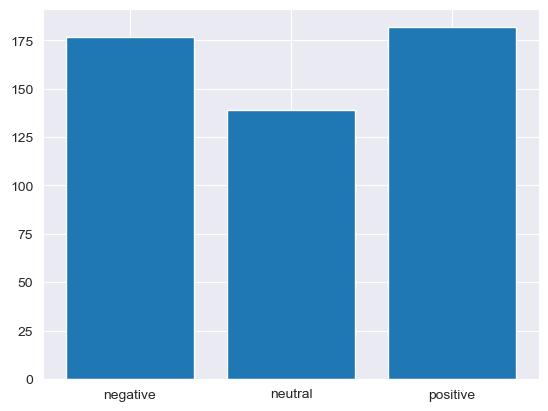

In [5]:
plot_label_count(test_df)

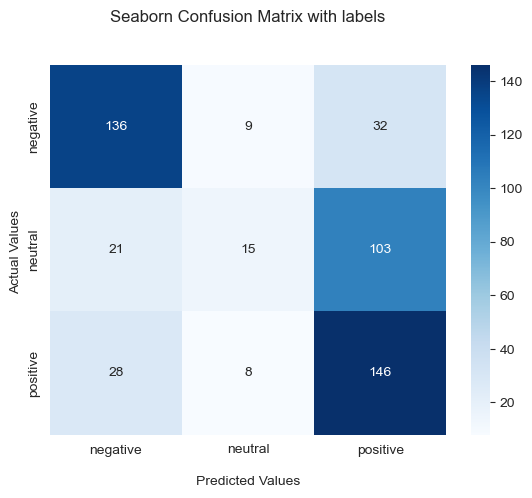

In [6]:
plot_confusion_matrix(confusion_matrix(test_df['target'], test_df['predictions']))

## Scrape and predict sentiment

# Setting variables to be used in format string command below
tweet_count = 1000
text_query = "shanghai"
since_date = "2020-06-01"
until_date = "now"

# Using OS library to call CLI commands in Python
os.system('snscrape --jsonl --max-results {} --since {} twitter-search "{} until:{}"> text-query-tweets.json'.format(
    tweet_count, since_date, text_query, until_date))
# Reads the json generated from the CLI command above and creates a pandas dataframe

In [18]:
keyword=["qatar", "world cup"]

In [3]:
sentiment, text_sentiment, tweet_df = scrape_and_predict(keyword=keyword, start_date="2012-01-1", end_date="now", max_tweets=10000)

Using custom data configuration SetFit--tweet_sentiment_extraction-60a81958566f1313
Found cached dataset json (C:/Users/20172613/.cache/huggingface/datasets/SetFit___json/SetFit--tweet_sentiment_extraction-60a81958566f1313/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:06<00:00,  3.33it/s]


tweet_df['sentiment_label'] = text_sentiment
tweet_df['text_length'] = [len(text) for text in tweet_df['content']]

In [21]:
df_name = "_".join(keyword) if type(keyword) == list else keyword
df_save_path = os.path.join(get_project_root(), Path(f"sentiment_model/checkpoints/scraped_dataset/df_{df_name}.p"))
pickle_save(tweet_df, df_save_path)

In [22]:
def plot_sentiment(tweet_df):
    sent_cl = np.unique(tweet_df["sentiment_label"])

    counts = [np.sum(np.array(tweet_df['sentiment_label']) == cl) for cl in sent_cl]

    fig, ax = plt.subplots(1,1)

    ax.bar(sent_cl, counts)
    return

def plot_text_lengths(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'negative'], shade=True, color="r", ax=ax, label="negative")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'neutral'], shade=True, color="b", ax=ax, label="neutral")
    sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'positive'], shade=True, color="g", ax=ax, label="positive")
    ax.set_xlim(-10, 500)
    ax.legend()
    ax.set_title("Text length per sentiment label")

def plot_date_dist(tweet_df):
    fig, ax = plt.subplots(1,1)
    sns.histplot(tweet_df['date'], ax=ax)

    ax.tick_params(axis='x', rotation=60)
    ax.set_title("Tweet frequency over time")

In [23]:
def plot_stacked_bar(tweet_df):
    sentiment_month = pd.DataFrame(tweet_df.groupby([tweet_df.date.dt.year, tweet_df.date.dt.month, 'sentiment_label']).size())

    years = []
    months = []
    sentiments = []

    datetime_col = pd.to_datetime({'year': [i[0] for i in list(sentiment_month.index)],
                             'month': [i[1] for i in list(sentiment_month.index)],
                             'day': [1 for i in range(len(sentiment_month.index))]})
    sentiments = [i[2] for i in list(sentiment_month.index)]
    sentiment_month = sentiment_month.reset_index(drop=True)
    sentiment_month["date"] = datetime_col
    sentiment_month["sentiment"] = sentiments

    totals = sentiment_month.groupby("date").sum()[0]

    def get_percentage(x):
        return x[0] / totals[x['date']]

    sentiment_month['ratio'] = sentiment_month.apply(get_percentage, axis=1)

    month_array = np.repeat(sentiment_month['date'].unique(), 3)
    sent_array = ['negative', 'neutral', 'positive'] * len(sentiment_month['date'].unique())

    df_montly_sentiment = pd.DataFrame({"date": month_array, "sentiment": sent_array, "ratio": np.zeros(len(month_array))})


    def get_ratio(x):
        ratio = sentiment_month[(sentiment_month['sentiment'] == x['sentiment']) & (sentiment_month['date'] == x['date'])]['ratio']
        if not len(ratio) == 0:
            return ratio.iloc[0]

        else:
            return 0


    df_montly_sentiment['ratio'] =  df_montly_sentiment.apply(get_ratio, axis=1)
    df_montly_sentiment = df_montly_sentiment.sort_values('date', ignore_index=True)

    negative = df_montly_sentiment[df_montly_sentiment['sentiment'] == 'negative']['ratio'].to_numpy()
    neutral = df_montly_sentiment[df_montly_sentiment['sentiment'] == 'neutral']['ratio'].to_numpy()
    positive = df_montly_sentiment[df_montly_sentiment['sentiment'] == 'positive']['ratio'].to_numpy()
    dates = df_montly_sentiment[df_montly_sentiment['sentiment'] == 'negative']['date'].to_list()

    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.bar(dates, negative, width=10, color='r')
    ax.bar(dates, neutral, width=10, bottom=negative, color='b')
    ax.bar(dates, positive, width=10, bottom=negative+neutral, color='g')

    plt.show()
    return df_montly_sentiment

In [24]:
#plt.style.use('dark_background')
plt.style.use('seaborn-notebook')

C:\Users\20172613\AppData\Local\Temp\ipykernel_11492\381822038.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


C:\Users\20172613\AppData\Local\Temp\ipykernel_11492\2593387721.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  totals = sentiment_month.groupby("date").sum()[0]


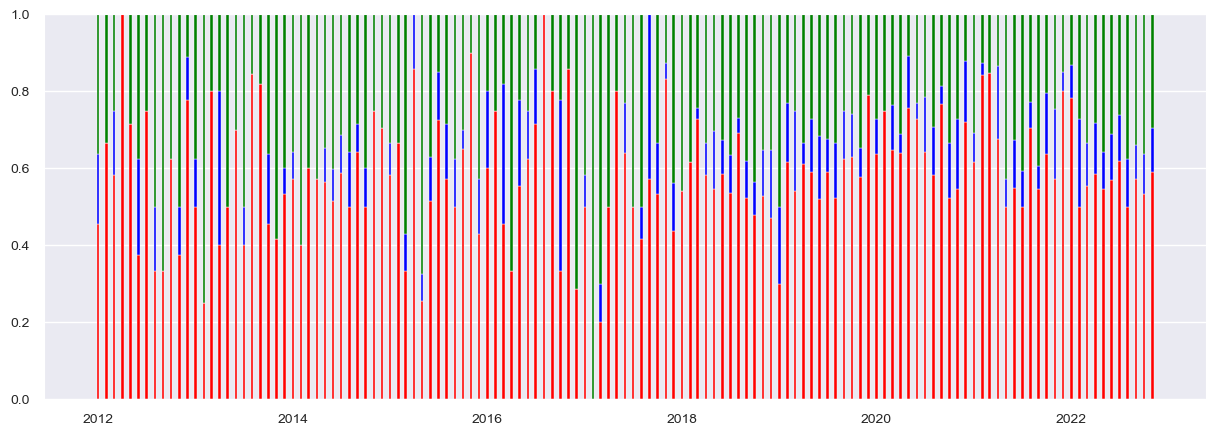

In [25]:
sent_month = plot_stacked_bar(tweet_df)

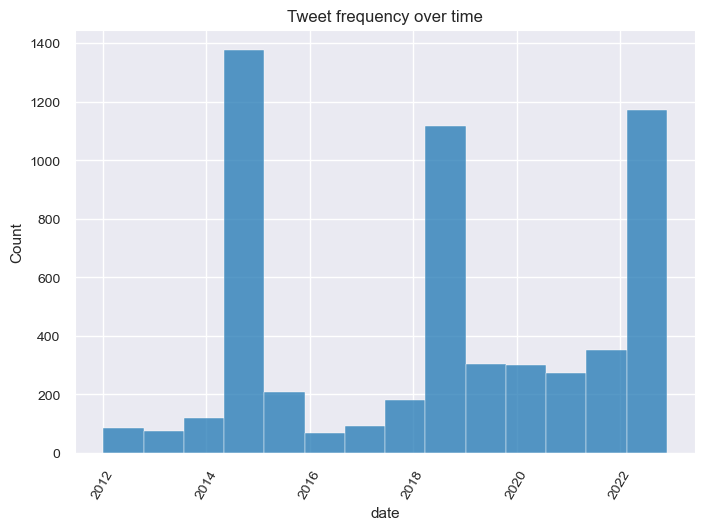

In [26]:
plot_date_dist(tweet_df)

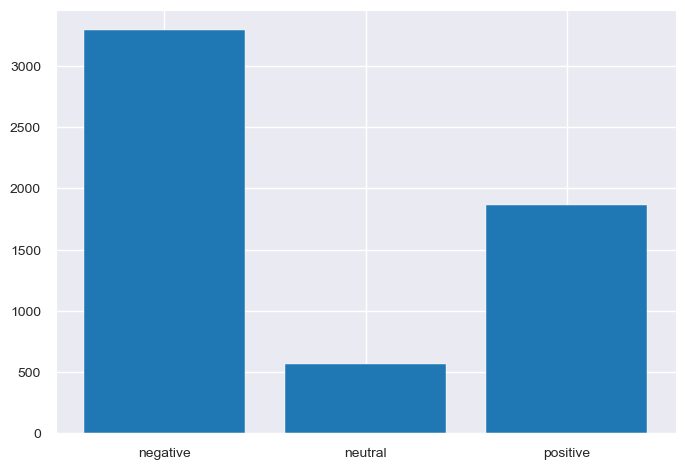

In [27]:
plot_sentiment(tweet_df)

C:\Users\20172613\AppData\Local\Temp\ipykernel_11492\1047928996.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'negative'], shade=True, color="r", ax=ax, label="negative")
C:\Users\20172613\AppData\Local\Temp\ipykernel_11492\1047928996.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_label'] == 'neutral'], shade=True, color="b", ax=ax, label="neutral")
C:\Users\20172613\AppData\Local\Temp\ipykernel_11492\1047928996.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet_df['text_length'][tweet_df['sentiment_lab

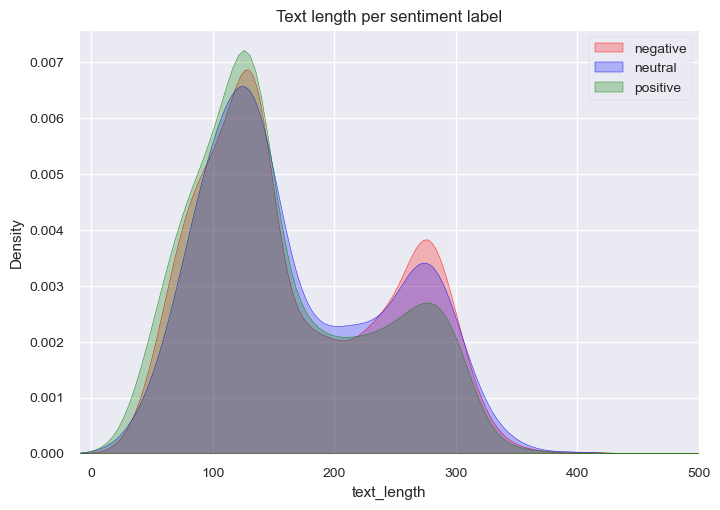

In [84]:
plot_text_lengths(tweet_df)

In [80]:
def get_word_cloud_text(tweet_df):
    tweet_tokens = []
    for tweet in tqdm(tweet_df['content']):
        tweet_tokens.extend(tokenize(tweet))

    return " ".join(token for token in tweet_tokens)


def get_word_cloud_text(tweet_df):
    all_tweets = " ".join(tweet for tweet in tweet_df['content'])
    all_tweets_tokens = process_token_list(tokenize(all_tweets))
    return " ".join(token for token in all_tweets_tokens)


def plot_word_cloud(tweet_df, keyword, sentiment_class=None):
    stopwords = set(STOPWORDS)
    stopwords.update({"<url>", "<user>", "user", "s", "url", "hashtag", "number", "n't", "now"})
    if type(keyword) == list:
        for word in keyword:
            if len(word.split()) > 1:
                stopwords.update({"".join(word.split())})

            for kw in word.split():
                stopwords.update({kw})

    else:
        stopwords.update(keyword)
    word_cloud = WordCloud(stopwords=stopwords, min_word_length=3, width=800, height=400)

    if not sentiment_class:
        text = get_word_cloud_text(tweet_df)
    else:
        text = get_word_cloud_text(tweet_df[tweet_df['sentiment_label'] == sentiment_class])

    word_cloud.generate(text)

    fig, ax = plt.subplots(1,1, figsize=(20,40))
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()



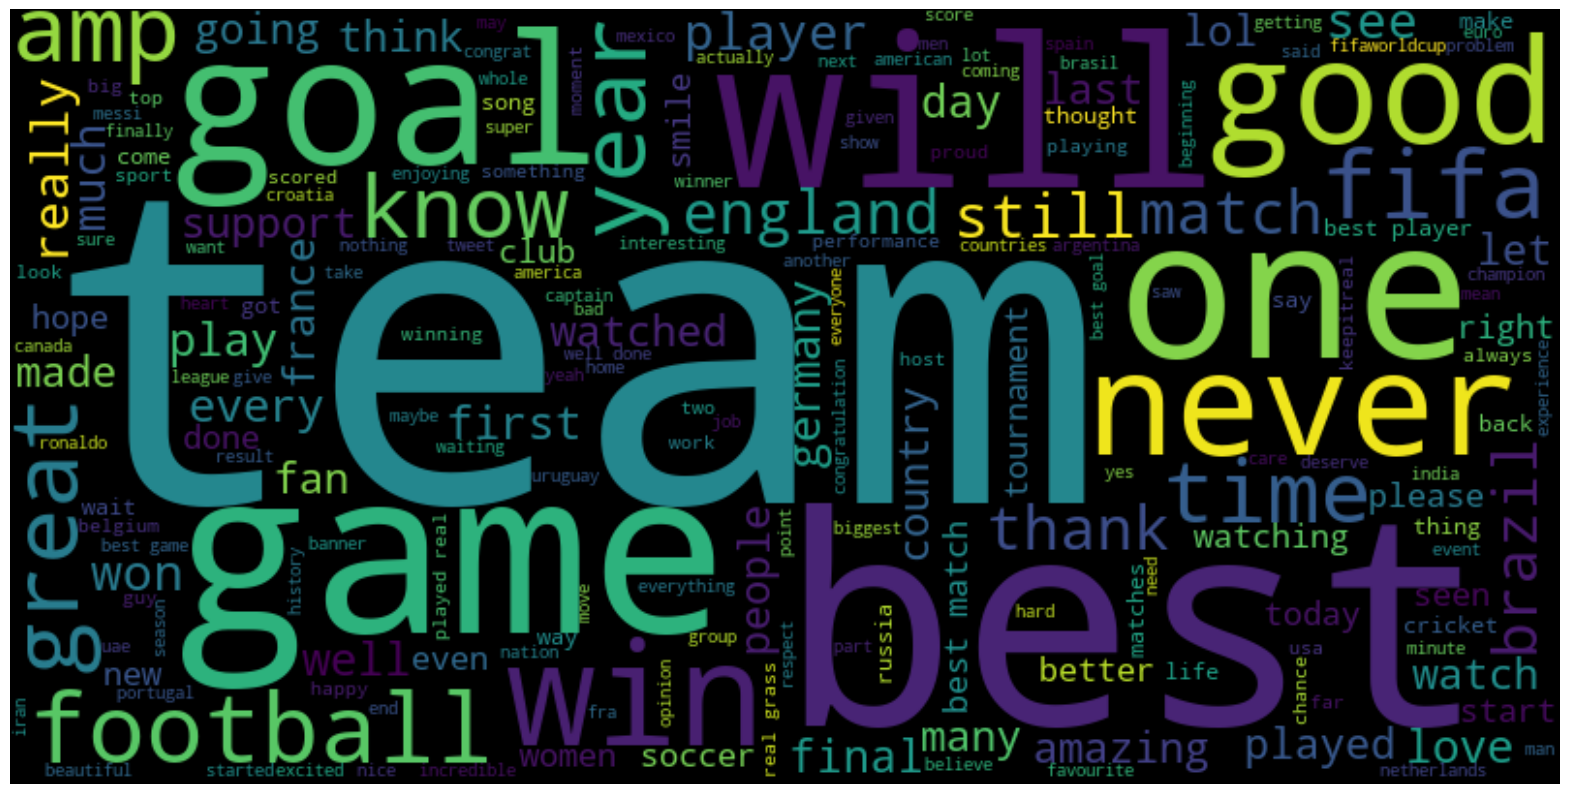

In [81]:
plot_word_cloud(tweet_df, keyword, "positive")

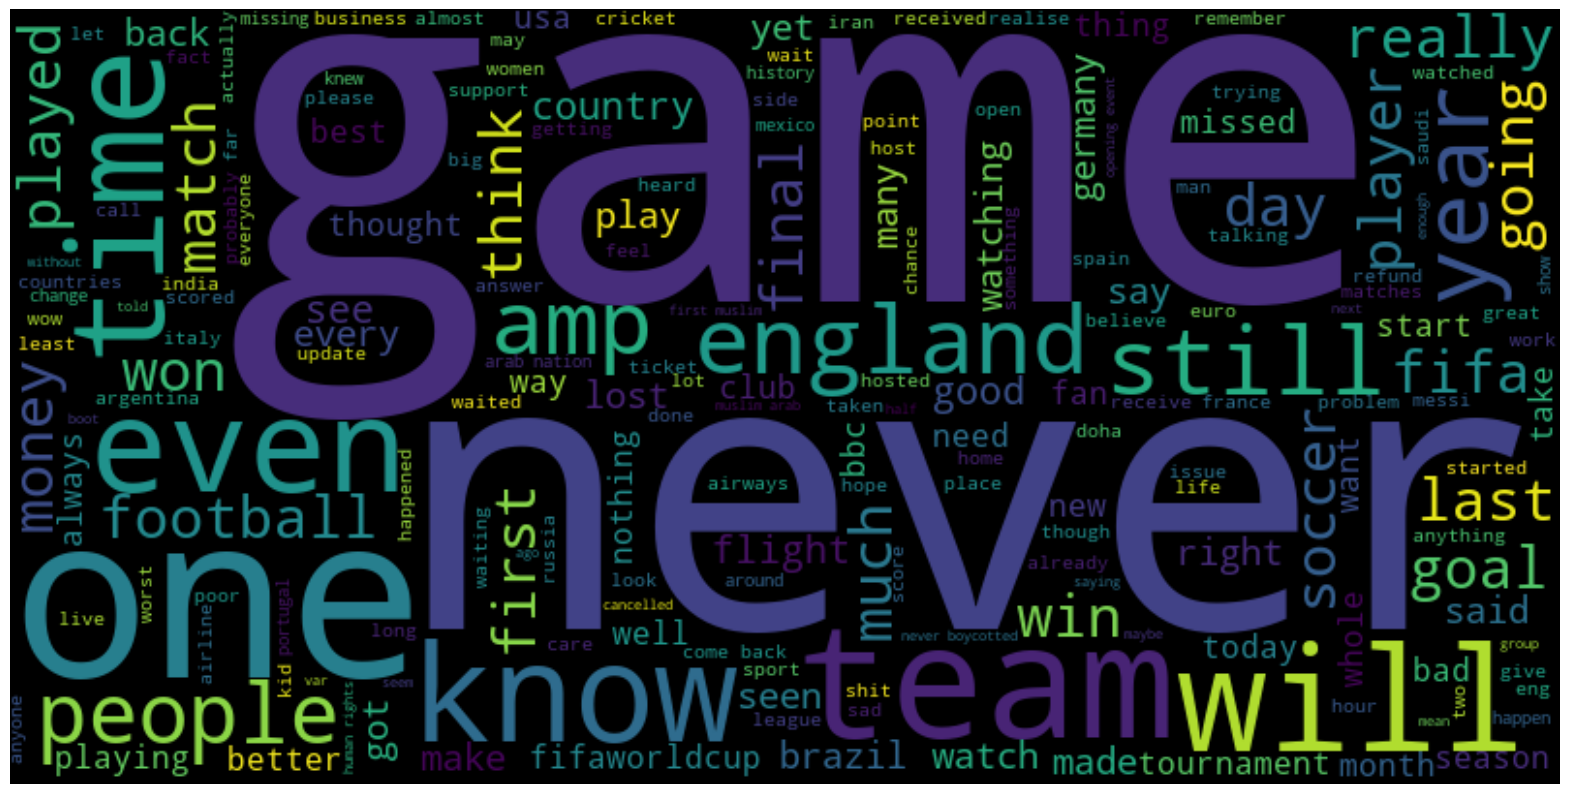

In [82]:
plot_word_cloud(tweet_df, keyword, "negative")

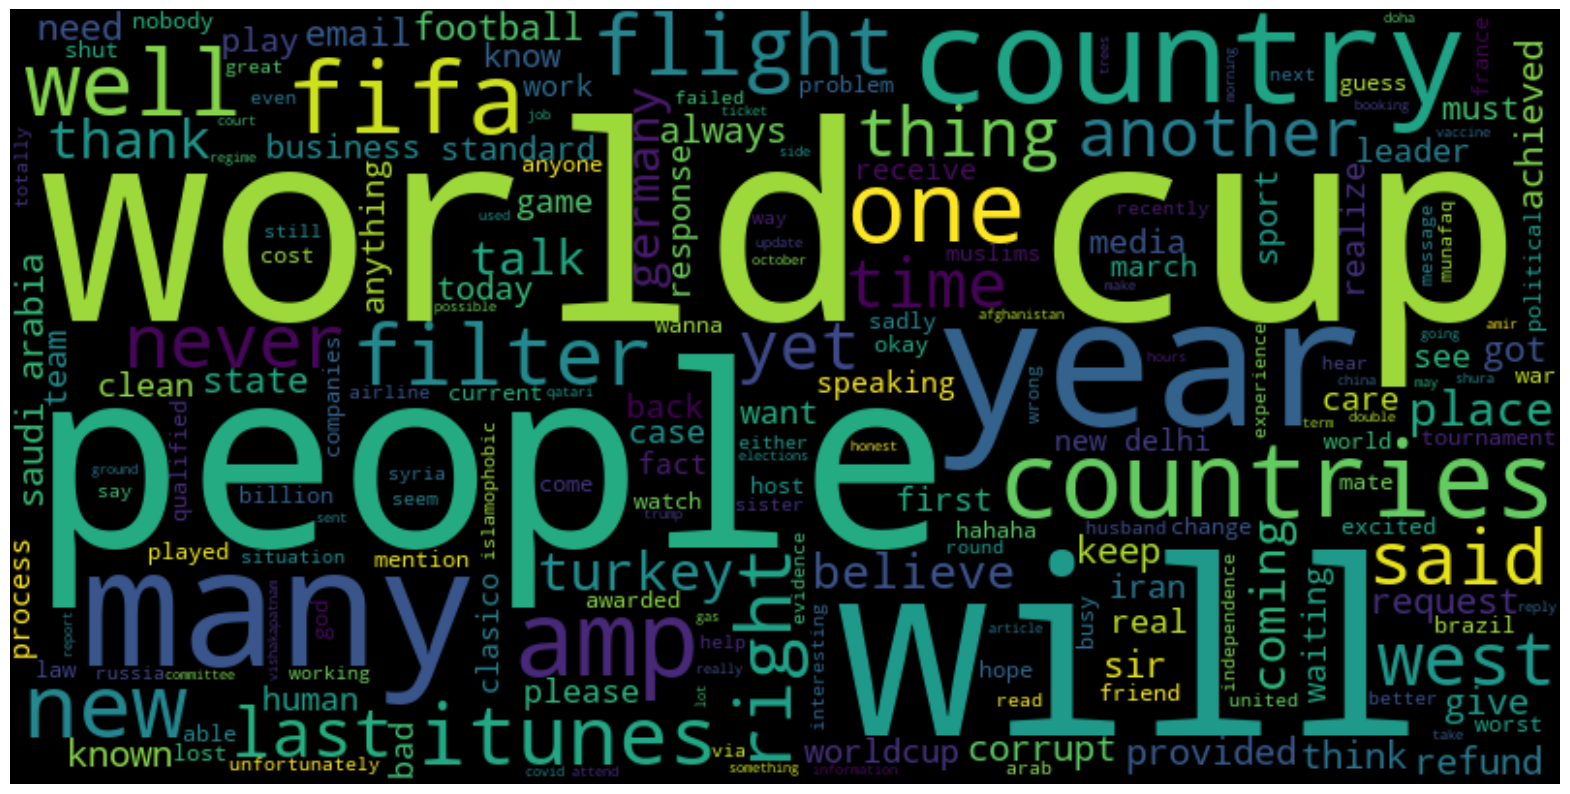

In [25]:
plot_word_cloud(tweet_df, keyword, "neutral")